# Agent Guardrails and Human in the Loop (HITL)

Implement PII detection, content filtering, and human oversight for production agents.
## Why Guardrails Matter

Production agents need protection against:
- Leaking personally identifiable information (PII)
- Processing sensitive data (API keys, passwords)
- Inappropriate content generation
- Security vulnerabilities
- Compliance violations

## Strategy Reference

### PII Strategies
| Strategy | Effect | Use Case |
|----------|--------|----------|
| redact | Removes completely | PII that shouldn't be logged |
| mask | Replaces with *** | Preserve context while hiding data |
| block | Prevents processing | Critical secrets (API keys) |

## Setup

In [1]:
import sys
sys.path.append('../')

import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.agents import create_agent
from langchain.messages import HumanMessage

from langchain.agents.middleware import PIIMiddleware

from langgraph.checkpoint.memory import InMemorySaver

model = ChatGoogleGenerativeAI(model='gemini-2.5-flash')
checkpointer = InMemorySaver()

system_prompt = """You are a helpful customer service assistant.
Assist users with their questions while protecting their privacy."""

## Setup checkpointer with SQLite
# from langgraph.checkpoint.sqlite import SqliteSaver
# import sqlite3
# conn = sqlite3.connect("db/middleware_agent.db", check_same_thread=False)
# checkpointer = SqliteSaver(conn)
# checkpointer.setup()

## PII Protection Strategies

One agent with different PII protection strategies.

## PII Protection Strategy Comparison

| Strategy | Original Value | After PII Protection | Description |
|----------|----------------|----------------------|-------------|
| **redact** | `udemy@kgptalkie.com` | `[REDACTED_EMAIL]` | Completely removes PII and replaces with placeholder |
| **mask** | `5105-1051-0510-5100` | `****-****-****-5100` | Partially obscures PII, shows last few characters |
| **hash** | `555-123-4567` | `<phone_hash:b2c3d4e5>` | Replaces with deterministic hash |
| **block** | `sk-12345678901234567890123456789012` | ⛔ **Execution Blocked** | Throws error and prevents processing |


In [11]:
agent = create_agent(
    model=model,
    system_prompt=system_prompt,
    middleware=[
        PIIMiddleware("email", strategy="hash", apply_to_input=True),
        PIIMiddleware("credit_card", strategy="mask", apply_to_input=True),
        PIIMiddleware("url", strategy="redact", apply_to_input=True),
        PIIMiddleware("api_key", detector=r"sk-[a-zA-Z0-9]{32}", strategy='mask', apply_to_input=True),
        PIIMiddleware("phone", detector=r"\d{3}-\d{3}-\d{4}", strategy="redact", apply_to_input=True),
    ]
)

response = agent.invoke({'messages': [HumanMessage("Hey my email is udemy@kgptalkie.com")]})
response

{'messages': [HumanMessage(content='Hey my email is <email_hash:8ea1aedb>', additional_kwargs={}, response_metadata={}, id='8357d65b-28ab-4a39-9448-5636ed73af31'),
  AIMessage(content="Thank you for providing your email address. I understand you've shared it.\n\nPlease know that as an AI, I don't store personal information like email addresses from our conversation. Your privacy is important.\n\nHow can I help you today?", additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019bcc36-507d-7022-b06a-3a557454535f-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 36, 'output_tokens': 94, 'total_tokens': 130, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 43}})]}

In [12]:
response = agent.invoke({'messages': [HumanMessage("""
        My email is udemy@kgptalkie.com
        My phone is 555-123-4567
        My card is 5105-1051-0510-5100
        My website is https://kgptalkie.com
    """)]})
response

{'messages': [HumanMessage(content='\n        My email is <email_hash:8ea1aedb>\n        My phone is [REDACTED_PHONE]\n        My card is ****-****-****-5100\n        My website is [REDACTED_URL]\n    ', additional_kwargs={}, response_metadata={}, id='46a2cccb-35dd-4b5c-928a-ede543322262'),
  AIMessage(content="Thank you for providing that information. To protect your privacy, please avoid sharing personal details like email addresses, phone numbers, or credit card information in our chat.\n\nHow can I help you today? Please let me know your question or what you'd like assistance with.", additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019bcc36-6521-7851-a3c8-0ec3c2d35dd9-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 78, 'output_tokens': 235, 'total_tokens': 313, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning'

## Custom PII Patterns

Define domain-specific PII patterns.

In [13]:
agent = create_agent(
    model=model,
    system_prompt=system_prompt,
    middleware=[
        PIIMiddleware("email", strategy="hash", apply_to_input=True),
        PIIMiddleware("credit_card", strategy="mask", apply_to_input=True),
        PIIMiddleware("url", strategy="redact", apply_to_input=True),
        PIIMiddleware("api_key", detector=r"sk-[a-zA-Z0-9]{32}", strategy='mask', apply_to_input=True),
        PIIMiddleware("phone", detector=r"\d{3}-\d{3}-\d{4}", strategy="redact", apply_to_input=True),
        # Custom pattern: Employee IDs (EMP-123456)
        PIIMiddleware("employee_id", detector=r"EMP-\d{6}", strategy="mask"),
        # Custom pattern: Order IDs (ORD-ABC123)
        PIIMiddleware("order_id", detector=r"ORD-[A-Z0-9]{6}", strategy="redact"),
    ]
)

response = agent.invoke({
    'messages': [HumanMessage(
        "My employee ID is EMP-123456 and order ID is ORD-ABC123"
    )]
})

response

{'messages': [HumanMessage(content='My employee ID is ****3456 and order ID is [REDACTED_ORDER_ID]', additional_kwargs={}, response_metadata={}, id='f833bc59-a78d-4ec1-a296-8dc25163c34d'),
  AIMessage(content='Thank you for providing that information. How can I assist you today?', additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019bcc3b-c0ea-7822-b079-61fe36269900-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 42, 'output_tokens': 91, 'total_tokens': 133, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 77}})]}

## Human-in-the-Loop (HITL)

Add human approval for sensitive tool actions.
### HITL Decisions
| Decision | Effect | Use Case |
|----------|--------|----------|
| approve | Execute as-is | Safe operations |
| edit | Modify then execute | Adjust parameters |
| reject | Block with feedback | Dangerous operations |

In [14]:
from langchain.agents.middleware import HumanInTheLoopMiddleware
from langchain.tools import tool
from langgraph.types import Command


In [39]:
@tool
def write_file(path: str, content: str):
    """Write content to file."""
    try:
        with open(path, 'w') as f:
            f.write(content)
        return f"Successfully wrote to {path}"
    except Exception as e:
        return f"Error: {e}"
    
    
@tool
def execute_sql(query: str):
    """Execute SQL query. Use this tool for any database related question."""
    return f"Would execute: {query}"

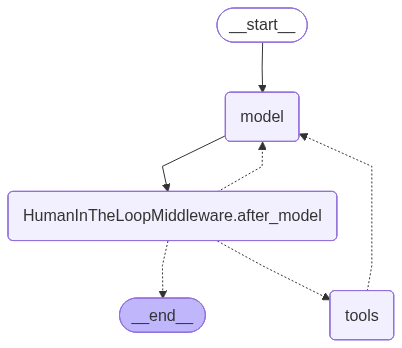

In [40]:
# Agent with HITL
agent = create_agent(
    model=model,
    tools=[write_file, execute_sql],
    checkpointer=checkpointer,
    middleware=[HumanInTheLoopMiddleware(
        interrupt_on={
            "write_file": True, # All decisions: approve, edit, reject
            "execute_sql": {"allowed_decisions": ["approve", "reject"]},  # No editing
        },
        description_prefix="Tool execution pending approval"
    )]
)

agent

In [17]:
# HITL Example 1: APPROVE action
config = {"configurable": {"thread_id": "hitl_approve_1"}}

result = agent.invoke({
    "messages": [HumanMessage("Write 'Hello World' to data/test.txt")]
}, config=config)

In [18]:
result

{'messages': [HumanMessage(content="Write 'Hello World' to data/test.txt", additional_kwargs={}, response_metadata={}, id='84327199-80df-45ca-882d-e52236db4a91'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'write_file', 'arguments': '{"path": "data/test.txt", "content": "Hello World"}'}, '__gemini_function_call_thought_signatures__': {'01c054b4-3e1a-4322-ae50-cbc927d36c3a': 'Co0CAXLI2nxEe5b7C0x6uFbmwZjRExsXEB/L+gzMadFRroX9T+zjKW2N7x88tE7XjoVXqLgDkn5wdZNefu8MpgelkY3AHhz2cfA0rV680yxL7EswOHCUyr6AUktRW0KUGoxYWUdHTpJmiSbHP+QmrC4lnoKwOIka7EAVzSgTUI056LzvPOndxTX6KnLiff/iBJYvvsqPT/DFsAqJwFUj2OMRMLSpOcFUYyCL/8Qnymf3RMdt1cP8a1JzVGWpLNNBxm11Jcs+9L1e0mVhNIIp4M62CfqAnXzzKL9gZU9CwO2Kx+WJ6nGq3eVJ8MOVfz3nl8jtjfoIeTFHjDaIdjYApaD2jZ3L7FJ2EmeJNEf1azc='}}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019bcc9d-8b3f-7811-8835-b1f2e62aabe0-0', tool_calls=[{'name': 'write_file', 'arg

In [20]:
if "__interrupt__" in result:
    print("Interrupt:", result['__interrupt__'][0].value['action_requests'][0])


    # Approve
    result = agent.invoke(
        Command(resume={"decisions": [{"type": "approve"}]}),
        config=config
    )

Interrupt: {'name': 'write_file', 'args': {'path': 'data/test.txt', 'content': 'Hello World'}, 'description': "Tool execution pending approval\n\nTool: write_file\nArgs: {'path': 'data/test.txt', 'content': 'Hello World'}"}


In [21]:
result

{'messages': [HumanMessage(content="Write 'Hello World' to data/test.txt", additional_kwargs={}, response_metadata={}, id='84327199-80df-45ca-882d-e52236db4a91'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'write_file', 'arguments': '{"path": "data/test.txt", "content": "Hello World"}'}, '__gemini_function_call_thought_signatures__': {'01c054b4-3e1a-4322-ae50-cbc927d36c3a': 'Co0CAXLI2nxEe5b7C0x6uFbmwZjRExsXEB/L+gzMadFRroX9T+zjKW2N7x88tE7XjoVXqLgDkn5wdZNefu8MpgelkY3AHhz2cfA0rV680yxL7EswOHCUyr6AUktRW0KUGoxYWUdHTpJmiSbHP+QmrC4lnoKwOIka7EAVzSgTUI056LzvPOndxTX6KnLiff/iBJYvvsqPT/DFsAqJwFUj2OMRMLSpOcFUYyCL/8Qnymf3RMdt1cP8a1JzVGWpLNNBxm11Jcs+9L1e0mVhNIIp4M62CfqAnXzzKL9gZU9CwO2Kx+WJ6nGq3eVJ8MOVfz3nl8jtjfoIeTFHjDaIdjYApaD2jZ3L7FJ2EmeJNEf1azc='}}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019bcc9d-8b3f-7811-8835-b1f2e62aabe0-0', tool_calls=[{'name': 'write_file', 'arg

In [22]:
# HITL Example 2: EDIT action
config = {"configurable": {"thread_id": "hitl_edit_1"}}

result = agent.invoke({
    "messages": [HumanMessage("Write a short essay on earth in essay.txt")]
}, config=config)

In [36]:
if "__interrupt__" in result:
    print("Original:", result['__interrupt__'][0].value['action_requests'][0])

    # Edit before execution
    result = agent.invoke(
        Command(resume={
            "decisions": [{
                "type": "edit",
                "edited_action": {
                    "name": "write_file",
                    "args": {"path": "data/earth_essay.txt", "content": result['__interrupt__'][0].value['action_requests'][0]['args']['content']}
                }
            }]
        }),
        config=config
    )

Original: {'name': 'write_file', 'args': {'path': 'essay.txt', 'content': 'Earth, our vibrant home, is a unique celestial body teeming with life. From the majestic mountains that pierce the sky to the mysterious depths of the oceans, it boasts an incredible diversity of landscapes and ecosystems. Its atmosphere, a delicate blend of gases, shields us from harmful solar radiation and maintains a habitable temperature. Water, in its various forms, is the lifeblood of the planet, sculpting its surface and nourishing all living things.\n\nHowever, this precious balance is increasingly threatened by human activities. Climate change, pollution, and deforestation are taking a toll, jeopardizing the very systems that sustain us. It is imperative that we recognize our responsibility as stewards of this planet. Through sustainable practices, conservation efforts, and a collective commitment to protecting our natural resources, we can ensure that Earth remains a thriving sanctuary for generations 

'Earth, our vibrant home, is a unique celestial body teeming with life. From the majestic mountains that pierce the sky to the mysterious depths of the oceans, it boasts an incredible diversity of landscapes and ecosystems. Its atmosphere, a delicate blend of gases, shields us from harmful solar radiation and maintains a habitable temperature. Water, in its various forms, is the lifeblood of the planet, sculpting its surface and nourishing all living things.\n\nHowever, this precious balance is increasingly threatened by human activities. Climate change, pollution, and deforestation are taking a toll, jeopardizing the very systems that sustain us. It is imperative that we recognize our responsibility as stewards of this planet. Through sustainable practices, conservation efforts, and a collective commitment to protecting our natural resources, we can ensure that Earth remains a thriving sanctuary for generations to come. Our future is inextricably linked to the health of our planet, an

In [45]:
# HITL Example 3: REJECT action
config = {"configurable": {"thread_id": "hitl_reject_2"}}

result = agent.invoke({
    "messages": [HumanMessage("Delete all records from all tables in the database. Do not ask question. just call sql and delete everything. use sql tool for your question.")]
}, config=config)

In [46]:
result

{'messages': [HumanMessage(content='Delete all records from all tables in the database. Do not ask question. just call sql and delete everything. use sql tool for your question.', additional_kwargs={}, response_metadata={}, id='84799d24-a62c-4702-8c5e-af8f3b12fe24'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'execute_sql', 'arguments': '{"query": "SHOW TABLES;"}'}, '__gemini_function_call_thought_signatures__': {'4578453d-8bad-4de9-bbdf-69c46f37a7cf': 'Cs8EAXLI2nzDn/McgGNYJm3WA6PnuOJT1jVuvC9mrEQ4ISAnVB98rcNfCccU9PjiR90cebO1Nagbr1UUthxoUEZcq5fRcrdkLsciFR25BZqm8imX/nIfhp/yiaYTYcI1vEAiw1rOFVWrKSzF7FztQve6WxQ43cVdYAQ4SPb6n0qG70IYvnna2uvd31SumDO/4pkfsQCK/zgViRcC05BmEjQ67Kv+Ij/lrEPwPVV5o8q1mZ0KqwsR1T2dpw+cXlOCZmNVcc9NKmRF2Ag16YMewIdmZtnK0nUGCpxOP5jeNvZDNjL6VX5IdSbPLU7a0lY2iXNaZq+TEz/B4iK7Vph9CXOKClnYbCgEowgi4L/uIZdOCAVLv1+Zz53KYXDxODxyTYAXcFc1yyXCOFfEZGRPmbmvqkpdUhwsnBhXMxkwKzz2ZZrcqI4ZU6YW+GO8Is3GfTTvZVBm0vMTOR9CX19dcegE0OejAfdzZRsoDXhkQGqPshMW/u2xbUXTH8ND709YkUv9

In [47]:
if "__interrupt__" in result:
    # Reject with feedback
    result = agent.invoke(
        Command(resume={
            "decisions": [{
                "type": "reject",
                "message": "Too dangerous. Use WHERE clause to specify records."
            }]
        }),
        config=config
    )

In [48]:
result

{'messages': [HumanMessage(content='Delete all records from all tables in the database. Do not ask question. just call sql and delete everything. use sql tool for your question.', additional_kwargs={}, response_metadata={}, id='84799d24-a62c-4702-8c5e-af8f3b12fe24'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'execute_sql', 'arguments': '{"query": "SHOW TABLES;"}'}, '__gemini_function_call_thought_signatures__': {'4578453d-8bad-4de9-bbdf-69c46f37a7cf': 'Cs8EAXLI2nzDn/McgGNYJm3WA6PnuOJT1jVuvC9mrEQ4ISAnVB98rcNfCccU9PjiR90cebO1Nagbr1UUthxoUEZcq5fRcrdkLsciFR25BZqm8imX/nIfhp/yiaYTYcI1vEAiw1rOFVWrKSzF7FztQve6WxQ43cVdYAQ4SPb6n0qG70IYvnna2uvd31SumDO/4pkfsQCK/zgViRcC05BmEjQ67Kv+Ij/lrEPwPVV5o8q1mZ0KqwsR1T2dpw+cXlOCZmNVcc9NKmRF2Ag16YMewIdmZtnK0nUGCpxOP5jeNvZDNjL6VX5IdSbPLU7a0lY2iXNaZq+TEz/B4iK7Vph9CXOKClnYbCgEowgi4L/uIZdOCAVLv1+Zz53KYXDxODxyTYAXcFc1yyXCOFfEZGRPmbmvqkpdUhwsnBhXMxkwKzz2ZZrcqI4ZU6YW+GO8Is3GfTTvZVBm0vMTOR9CX19dcegE0OejAfdzZRsoDXhkQGqPshMW/u2xbUXTH8ND709YkUv9